# Flights Canceled or Delayed by Airline Reservation System Problems

By Josh Romero

An initial analysis to see whether it's possible to match specific cancellations and delays to incidents reported in the news.

In [27]:
import pandas as pd

from datetime import date
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
# plt.style.use('ggplot')
plt.style.use('seaborn')

We'll use the "[On-Time: On-Time Performance](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time)" database from TranStats (Bureau of Transportation Statistics) to find delayed and canceled flights. To prototype, we'll start by looking at just one month (Jan 2017).

In [28]:
flight_data = 'raw_data/On_Time_On_Time_Performance_2017_1.csv'

The database of flights is quite large, with lots of columns we don't need (at least for now). Here is a list of the columns that seem like they'll be useful from the [table contents](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time) list.

In [29]:
#TODO Use column names instead of indices
cols = [
    5,6,10,11,14,23,29,30,31,32,36,37,38,39,
    40,41,42,43,47,48,49,56,57,58,59,60
]

Some of the columns are keys to other lookup tables (available as separate CSV files). We'll read in these smaller files as dictionaries first, so we can do things like expand carrier codes to full airline names.

In [30]:
# Careful! There's an carrier code of 'NA' that Pandas will convert to NaN by default, so set keep_default_na to False
# https://stackoverflow.com/questions/16596188/pandas-convert-na-to-nan

# Because we want to use the first row as keys for our dict, we have to transpose it.
# And the 'records' argument returns the dict we want wrapped in a list, so we just use [0] to get the dict itself
carrier_dict = pd.read_csv(
        'raw_data/lookup_tables/L_UNIQUE_CARRIERS.csv',
        index_col=0,
        keep_default_na=False
    ).T.to_dict('records')[0]

# carrier_dict

Now we'll load the main data. For now, we're only interested in flights that were canceled or delayed due to carrier problems  (ignore delays due to weather, air traffic control systems, or missing planes), and getting rid of all the on-time flights will give us a much more manageable dataset.

In [31]:
# Load in chunks to avoid overloading memory
iter_csv = pd.read_csv(
        flight_data, iterator=True, chunksize=1000, usecols=cols
    )

# TODO: Consider renaming columns with British spelling of "Cancelled" to "Canceled for consistency with
# the descriptive text and AP style.
disrupted = pd.concat([chunk[(
        chunk['Cancelled'] > 0
    ) | (
        chunk['CarrierDelay'] > 0
    )] for chunk in iter_csv])

In [32]:
# Add lookup columns and coerce datetimes
disrupted['LUniqueCarrier'] = disrupted.UniqueCarrier.map(carrier_dict).str.replace(r'\w*(Inc.|Co.)', '')
disrupted.FlightDate = pd.to_datetime(disrupted.FlightDate)
disrupted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57441 entries, 3 to 449993
Data columns (total 27 columns):
FlightDate           57441 non-null datetime64[ns]
UniqueCarrier        57441 non-null object
FlightNum            57441 non-null int64
OriginAirportID      57441 non-null int64
Origin               57441 non-null object
Dest                 57441 non-null object
CRSDepTime           57441 non-null int64
DepTime              48900 non-null float64
DepDelay             48900 non-null float64
DepDelayMinutes      48900 non-null float64
TaxiOut              48668 non-null float64
WheelsOff            48668 non-null float64
WheelsOn             48555 non-null float64
TaxiIn               48555 non-null float64
CRSArrTime           57441 non-null int64
ArrTime              48555 non-null float64
ArrDelay             48555 non-null float64
ArrDelayMinutes      48555 non-null float64
Cancelled            57441 non-null float64
CancellationCode     8886 non-null object
Diverted        

Now that we have our dataset, we'll split it to look at cancellations and delays separately.

In [33]:
canceled = disrupted[disrupted['Cancelled'] > 0]
delayed = disrupted[disrupted['CarrierDelay'] > 0]

## Canceled Flights
First, let's see which carriers had the most canceled flights this month.

In [34]:
carrier_group_ca = canceled[[
        'LUniqueCarrier','FlightDate','Cancelled'
    ]].groupby('LUniqueCarrier').size().sort_values(ascending=False).reset_index()

carrier_group_ca

,LUniqueCarrier,0
0,Southwest Airlines,2313
1,SkyWest Airlines,1880
2,ExpressJet Airlines,1159
3,American Airlines,980
4,Delta Air Lines,782
5,JetBlue Airways,525
6,Spirit Air Lines,441
7,Alaska Airlines,257
8,United Air Lines,232
9,Frontier Airlines,162


In [35]:
ordered_carriers_ca = carrier_group_ca.LUniqueCarrier.tolist()

Next, let's see when in the month those cancellations occured for each carrier.

In [36]:
canceled_by_date = canceled.pivot_table(
        index='FlightDate', columns='LUniqueCarrier', values='Cancelled', aggfunc='sum'
    )[ordered_carriers_ca] # Re-sort columns by most cancellations

canceled_by_date

LUniqueCarrier,Southwest Airlines,SkyWest Airlines,ExpressJet Airlines,American Airlines,Delta Air Lines,JetBlue Airways,Spirit Air Lines,Alaska Airlines,United Air Lines,Frontier Airlines,Virgin America,Hawaiian Airlines
FlightDate,,,,,,,,,,,,
2017-01-01,11.0,4.0,5.0,12.0,NaN,NaN,21.0,40.0,NaN,NaN,NaN,NaN
2017-01-02,125.0,85.0,106.0,3.0,NaN,NaN,20.0,1.0,5.0,4.0,2.0,NaN
2017-01-03,50.0,114.0,46.0,9.0,NaN,NaN,10.0,9.0,12.0,9.0,17.0,NaN
2017-01-04,13.0,91.0,9.0,36.0,1.0,3.0,2.0,8.0,18.0,25.0,15.0,NaN
2017-01-05,53.0,120.0,25.0,27.0,2.0,7.0,NaN,6.0,11.0,33.0,3.0,NaN
2017-01-06,177.0,47.0,195.0,105.0,203.0,91.0,61.0,2.0,43.0,10.0,6.0,NaN
2017-01-07,356.0,101.0,182.0,264.0,230.0,214.0,124.0,32.0,23.0,26.0,18.0,1.0
2017-01-08,154.0,176.0,48.0,163.0,49.0,49.0,26.0,49.0,31.0,9.0,23.0,1.0
2017-01-09,82.0,118.0,9.0,62.0,2.0,19.0,10.0,3.0,9.0,NaN,3.0,NaN


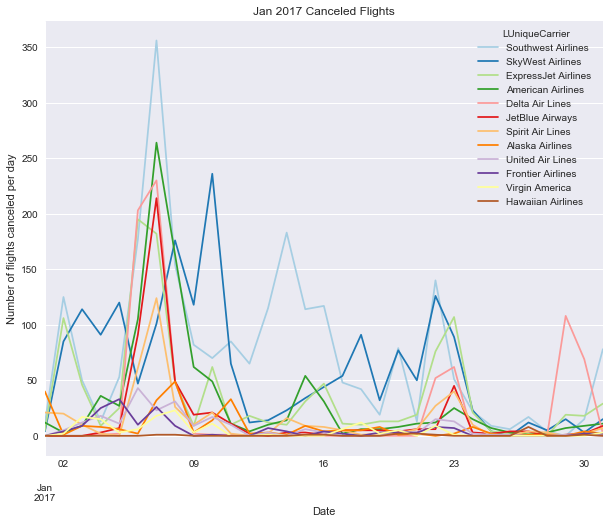

In [37]:
cancel_plot = canceled_by_date.fillna(0).plot(
        figsize=(10, 8), colormap='Paired', title="Jan 2017 Canceled Flights"
    )
cancel_plot.set_ylabel('Number of flights canceled per day')
cancel_plot.set_xlabel('Date')

It looks like Soutwest struggled with cancellations througout the month, as did SkyWest to a lesser extent. There's some other notable cancellation spikes for individual airlines, but it looks like many carriers had probems around January 7th. Let's see the aggregate:

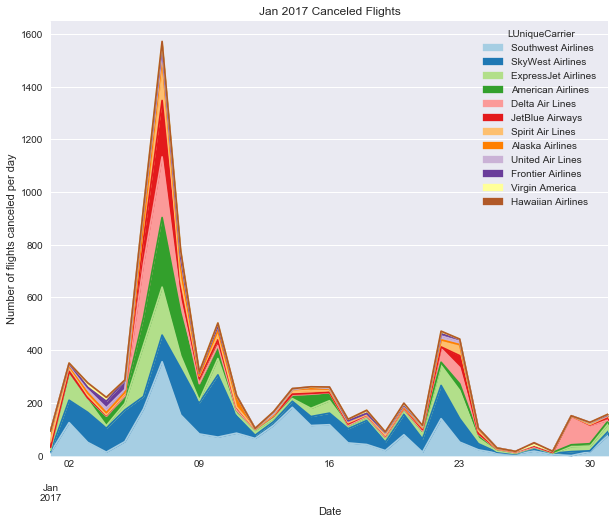

In [38]:
agg_cancel_plot = canceled_by_date.fillna(0).plot(
        kind='area', colormap='Paired', stacked=True, figsize=(10, 8), title="Jan 2017 Canceled Flights"
    )
agg_cancel_plot.set_ylabel('Number of flights canceled per day')
agg_cancel_plot.set_xlabel('Date')

We can see that January 6-8 saw a large number of cancellations across carriers, and the last week of the month was much better than the first three.

Now let's turn to delays

## Carrier-delayed Flights

In [39]:
delayed.head()

,FlightDate,UniqueCarrier,FlightNum,OriginAirportID,Origin,Dest,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,...,ArrDelayMinutes,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,LUniqueCarrier
3,2017-01-20,AA,494,11057,CLT,PHX,1619,1656.0,37.0,37.0,...,33.0,0.0,NaN,0.0,33.0,0.0,0.0,0.0,0.0,American Airlines
23,2017-01-22,AA,494,11697,FLL,CLT,1305,1350.0,45.0,45.0,...,36.0,0.0,NaN,0.0,8.0,0.0,0.0,0.0,28.0,American Airlines
33,2017-01-04,AA,494,14635,RSW,CLT,1315,1338.0,23.0,23.0,...,20.0,0.0,NaN,0.0,20.0,0.0,0.0,0.0,0.0,American Airlines
44,2017-01-07,AA,495,10397,ATL,PHX,1130,1251.0,81.0,81.0,...,153.0,0.0,NaN,0.0,81.0,0.0,72.0,0.0,0.0,American Airlines
64,2017-01-11,AA,495,14122,PIT,PHX,1001,1011.0,10.0,10.0,...,20.0,0.0,NaN,0.0,10.0,0.0,10.0,0.0,0.0,American Airlines


Again, let's start by seeing which airlines had the most delayed flights.

In [40]:
carrier_group_de = delayed[[
        'LUniqueCarrier','FlightDate','CarrierDelay'
    ]].groupby('LUniqueCarrier')

carrier_group_de_cnt = carrier_group_de.size().sort_values(ascending=False).reset_index()
carrier_group_de_cnt

,LUniqueCarrier,0
0,Southwest Airlines,13488
1,American Airlines,7268
2,Delta Air Lines,6555
3,United Air Lines,4656
4,JetBlue Airways,4248
5,SkyWest Airlines,4145
6,ExpressJet Airlines,4099
7,Frontier Airlines,1154
8,Alaska Airlines,859
9,Hawaiian Airlines,762


Not exactly a surprise that Southwest had the most delayed flights as well. Let's plot the delayed flights over time.

In [41]:
ordered_carriers_de_cnt = carrier_group_de_cnt.LUniqueCarrier.tolist()

In [42]:
delayed_cnt_by_date = delayed.pivot_table(
        index='FlightDate', columns='LUniqueCarrier', values='CarrierDelay', aggfunc='size'
    )[ordered_carriers_de_cnt] # Re-sort columns by most delays

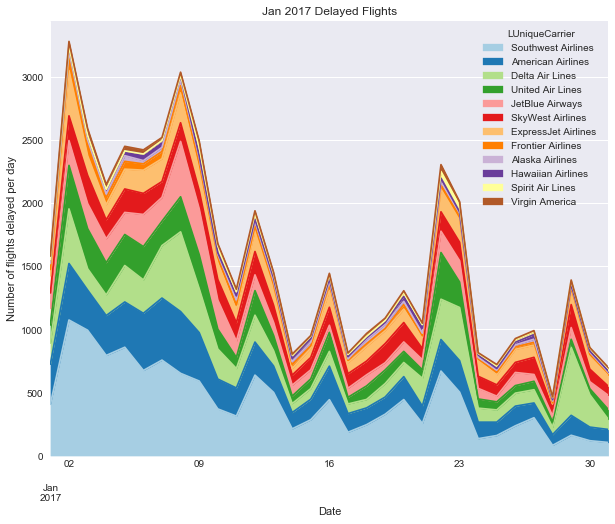

In [43]:
delay_cnt_plot = delayed_cnt_by_date.fillna(0).plot(
        kind='area', colormap='Paired', stacked=True, figsize=(10, 8), title="Jan 2017 Delayed Flights"
    )
delay_cnt_plot.set_ylabel('Number of flights delayed per day')
delay_cnt_plot.set_xlabel('Date')

This distribution looks quite different from the cancellations. While many airlines had persistent problems, there are a few spikes, particularly for Delta at the end of the month.

But with delays, we should also consider duration, not just frequency.

In [44]:
delay_totals = carrier_group_de.sum()
delay_totals.sort_values('CarrierDelay', ascending=False,)

,CarrierDelay
LUniqueCarrier,
Delta Air Lines,385953.0
ExpressJet Airlines,299209.0
Southwest Airlines,291141.0
SkyWest Airlines,291017.0
American Airlines,262291.0
United Air Lines,189305.0
JetBlue Airways,123024.0
Frontier Airlines,36930.0
Alaska Airlines,34787.0


Looks like Delta and Express Jet passengers had delays that lasted much longer. Let's look at aggregate delays by date.

In [45]:
delayed_cum_by_date = delayed.pivot_table(
        index='FlightDate', columns='LUniqueCarrier', values='CarrierDelay', aggfunc='sum'
    )[ordered_carriers_de_cnt] # Re-sort columns by most delays

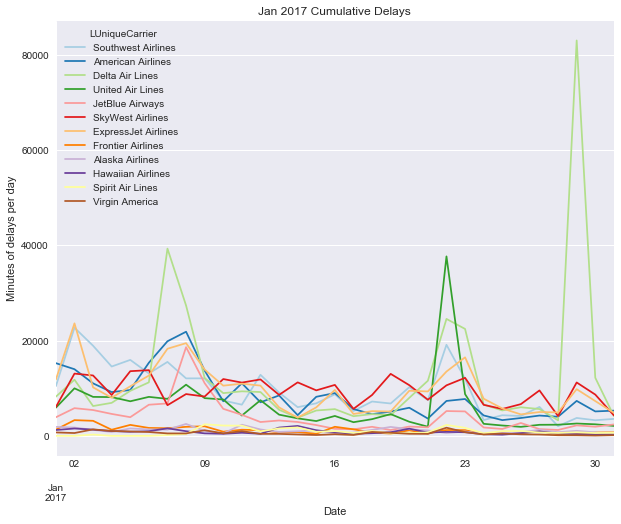

In [46]:
delay_cum_plot = delayed_cum_by_date.fillna(0).plot(
        colormap='Paired', figsize=(10, 8), title="Jan 2017 Cumulative Delays"
    )
delay_cum_plot.set_ylabel('Minutes of delays per day')
delay_cum_plot.set_xlabel('Date')

Now we can see some large spikes that look like they may be carrier-specific. Delta had at leat two major incidents, and United had one that caused much longer delays than other carriers had.

Let's take a look at United.

In [47]:
united_flights_de = delayed[delayed.UniqueCarrier == 'UA']

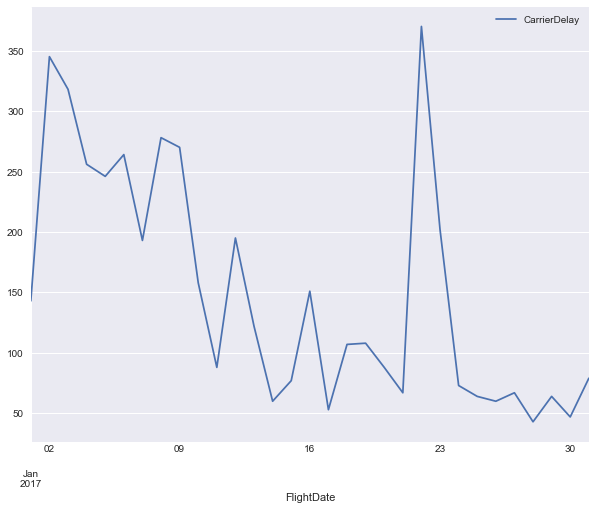

In [48]:
uf_dates_de = (
        united_flights_de.groupby('FlightDate', as_index=True)
        .count()
        .plot( y="CarrierDelay", figsize=(10, 8))
    )

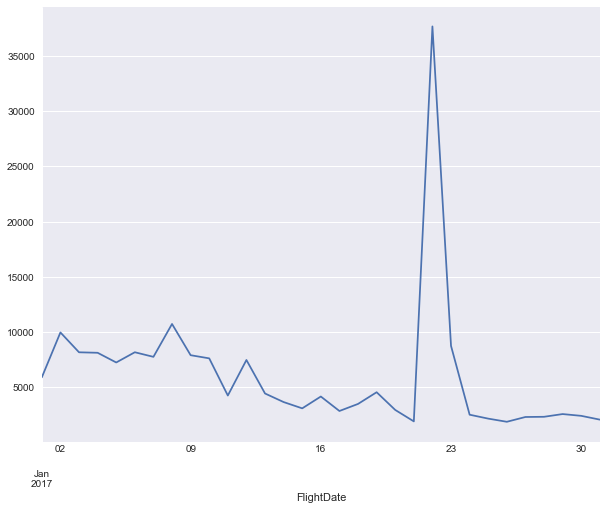

In [49]:
uf_dates = united_flights_de.groupby(
        'FlightDate', as_index=True
    ).CarrierDelay.sum().plot(y="CarrierDelay", figsize=(10, 8))
